<h1>Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Introduction" data-toc-modified-id="Introduction-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Introduction</a></span></li><li><span><a href="#Axes" data-toc-modified-id="Axes-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Axes</a></span></li><li><span><a href="#Colors" data-toc-modified-id="Colors-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Colors</a></span></li><li><span><a href="#Data" data-toc-modified-id="Data-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Data</a></span></li><li><span><a href="#The-color-magnitude-plot" data-toc-modified-id="The-color-magnitude-plot-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>The color-magnitude plot</a></span></li><li><span><a href="#The-orbital-parameters-plot" data-toc-modified-id="The-orbital-parameters-plot-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>The orbital parameters plot</a></span></li><li><span><a href="#Saving-data" data-toc-modified-id="Saving-data-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Saving data</a></span></li></ul></div>

## Introduction

Parker _et al_ published a paper on using SDSS moving object data to analyze size distributions of asteroid families: https://ui.adsabs.harvard.edu/abs/2008Icar..198..138P/abstract

The AstroML package used this as one of their examples to demonstrate data retrieval and plotting: https://github.com/astroML/astroML/blob/master/examples/datasets/plot_moving_objects.py

This notebook merely tweaks the example code slightly for Jupyter format. The data is saved as a pandas dataframe for use with other plotting packages.

In [80]:
# Author: Jake VanderPlas <vanderplas@astro.washington.edu>
# License: BSD
#   The figure is an example from astroML: see http://astroML.github.com
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
from astroML.datasets import fetch_moving_objects
from astroML.plotting.tools import devectorize_axes
import pandas as pd

## Axes

Set Matplotlib to draw white axes on a black background:

In [81]:
def black_bg_subplot(*args, **kwargs):
    """Create a subplot with black background"""

    if int(matplotlib.__version__[0]) >= 2:
        kwargs['facecolor'] = 'k'
    else:
        kwargs['axisbg'] = 'k'

    ax = plt.subplot(*args, **kwargs)

    # set ticks and labels to white
    for spine in ax.spines.values():
        spine.set_color('w')

    for tick in ax.xaxis.get_major_ticks() + ax.yaxis.get_major_ticks():
        for child in tick.get_children():
            child.set_color('w')

    return ax

## Colors 

Calculate plot colors to use, based on magnitudes in three SDSS filters:

In [82]:
def compute_color(mag_a, mag_i, mag_z, a_crit=-0.1):
    """
    Compute the scatter-plot color using code adapted from
    TCL source used in Parker 2008.
    """
    # define the base color scalings
    R = np.ones_like(mag_i)
    G = 0.5 * 10 ** (-2 * (mag_i - mag_z - 0.01))
    B = 1.5 * 10 ** (-8 * (mag_a + 0.0))

    # enhance green beyond the a_crit cutoff
    i = np.where(mag_a < a_crit)
    G[i] += 10000 * (10 ** (-0.01 * (mag_a[i] - a_crit)) - 1)

    # normalize color of each point to its maximum component
    RGB = np.vstack([R, G, B])
    RGB /= RGB.max(0)

    # return an array of RGB colors, which is shape (n_points, 3)
    return RGB.T

## Data

Fetch data and extract the desired quantities:

In [83]:
data = fetch_moving_objects(Parker2008_cuts=True)
mag_a = data['mag_a']
mag_i = data['mag_i']
mag_z = data['mag_z']
a = data['aprime']
sini = data['sin_iprime']

Dither points: magnitudes are recorded only to +/- 0.01

In [84]:
mag_a += -0.005 + 0.01 * np.random.random(size=mag_a.shape)
mag_i += -0.005 + 0.01 * np.random.random(size=mag_i.shape)
mag_z += -0.005 + 0.01 * np.random.random(size=mag_z.shape)

Compute RGB color based on magnitudes

In [85]:
color = compute_color(mag_a, mag_i, mag_z)

## The color-magnitude plot

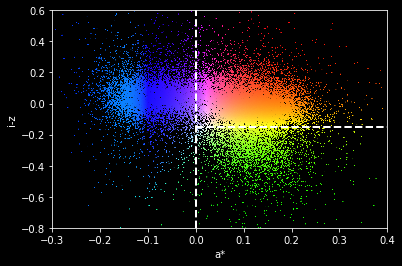

In [86]:
fig = plt.figure(facecolor='k')
ax = black_bg_subplot(111)
ax.scatter(mag_a, mag_i - mag_z,
           c=color, s=1, lw=0)
devectorize_axes(ax, dpi=400)

ax.plot([0, 0], [-0.8, 0.6], '--w', lw=2)
ax.plot([0, 0.4], [-0.15, -0.15], '--w', lw=2)

ax.set_xlim(-0.3, 0.4)
ax.set_ylim(-0.8, 0.6)

ax.set_xlabel('a*', color='w')
ax.set_ylabel('i-z', color='w');

## The orbital parameters plot

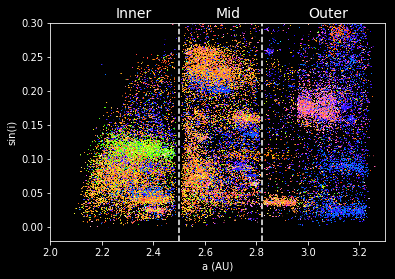

In [87]:
fig = plt.figure(facecolor='k')
ax = black_bg_subplot(111)
ax.scatter(a, sini,
           c=color, s=1, lw=0)
devectorize_axes(ax, dpi=400)

ax.plot([2.5, 2.5], [-0.02, 0.3], '--w')
ax.plot([2.82, 2.82], [-0.02, 0.3], '--w')

ax.set_xlim(2.0, 3.3)
ax.set_ylim(-0.02, 0.3)

ax.set_xlabel('a (AU)', color='w')
ax.set_ylabel('sin(i)', color='w')

# label the plot
text_kwargs = dict(color='w', fontsize=14,
                   transform=plt.gca().transAxes,
                   ha='center', va='bottom')

ax.text(0.25, 1.01, 'Inner', **text_kwargs)
ax.text(0.53, 1.01, 'Mid', **text_kwargs)
ax.text(0.83, 1.01, 'Outer', **text_kwargs);

## Saving data

In [88]:
# Saving the black-background figure requires some extra arguments:
#fig.savefig('moving_objects.png',
#            facecolor='black',
#            edgecolor='none')

Save the data as a Pandas dataframe for use in other notebooks. Magnitudes are now dithered and colors are in `#rrggbb` hex format.

In [93]:
df = pd.DataFrame(data)

color_int = np.rint(color*255)
colors = ['#{:02X}{:02X}{:02X}'.format(R,G,B) for (R,G,B) in color_int.astype(int)]

df['color'] = colors
df['mag_a'] = mag_a
df['mag_i'] = mag_i
df['mag_z'] = mag_z
df.to_pickle('moving_objects.pkl')

df[:5]

,moID,sdss_run,sdss_col,sdss_field,sdss_obj,rowc,colc,mjd,ra,dec,...,e,i,asc_node,arg_peri,M,PEcat_id,aprime,eprime,sin_iprime,color
0,b's0584d',1033,1,18,501,998.963989,227.925995,51464.17464,319.778532,-1.028106,...,0.089752,14.197422,207.942653,346.905410,119.862253,b'ASTDYS_N_20041008',3.01297,0.1441,0.2474,#C83BFF
1,b's05871',1033,1,26,84,447.126007,1859.880005,51464.17779,320.915442,-0.848570,...,0.083571,11.375531,230.393050,225.860346,234.376329,b'ASTDYS_N_20041008',3.02742,0.0856,0.2121,#FF69A3
2,b's0586a',1033,1,38,385,1075.329956,1557.660034,51464.18295,322.781026,-0.881779,...,0.207489,8.189944,274.373214,109.188165,118.278019,b'ASTDYS_U_20041008',2.35713,0.1738,0.1605,#FF5B9A
3,b's05869',1033,1,39,382,550.469971,1376.540039,51464.18321,322.873013,-0.901683,...,0.130971,12.570014,212.389797,10.351804,170.453137,b'ASTDYS_N_20041008',2.62381,0.1701,0.2203,#FFBA2B
4,b's058d2',1033,1,86,297,1003.840027,1547.680054,51464.20283,329.958783,-0.882237,...,0.107059,11.147634,301.617260,202.226731,262.960537,b'ASTDYS_N_20041008',2.66956,0.1465,0.2078,#AE38FF


Replot the first figure using the dataframe to check it's OK:

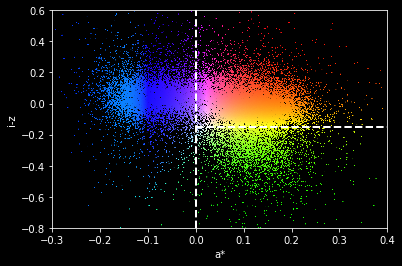

In [94]:
fig = plt.figure(facecolor='k')
ax = black_bg_subplot(111)
ax.scatter(df['mag_a'], df['mag_i'] - df['mag_z'],
           c=df['color'], s=1, lw=0)
devectorize_axes(ax, dpi=400)

ax.plot([0, 0], [-0.8, 0.6], '--w', lw=2)
ax.plot([0, 0.4], [-0.15, -0.15], '--w', lw=2)

ax.set_xlim(-0.3, 0.4)
ax.set_ylim(-0.8, 0.6)

ax.set_xlabel('a*', color='w')
ax.set_ylabel('i-z', color='w');